In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import scipy.special
import cv2

import torch

import networkx as nx

import pickle
from PIL import Image, ImageDraw
import matplotlib.lines as lines
from mpl_toolkits import mplot3d
from matplotlib.lines import Line2D

from tqdm import tqdm
import glob

import statistics 

#For network adjacency checks
from skimage.transform import rotate
from sklearn.neighbors import KDTree
from scipy.spatial import distance

#For PCA
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import pandas as pd

import warnings

np.seterr(all='raise')
scipy.special.seterr(all='raise')

from lineage_timeless import lineage_timeless
from network_object import network_object
from cell_object import cell_object

In [2]:
globalpath = "/Volumes/TC_backup/Comprehensive"

lineage_list = []

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/*.lineage")), position=0, leave=True, desc = globalpath):
    templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
    templineage.load_object(fin = lineage_path)
    if len(templineage.items) > 10:
        lineage_list.append(templineage)

lineage_list = [lineage for lineage in lineage_list]# if "p3" not in lineage.tag]
for lineage in lineage_list:
    lineage.tag = os.path.split(lineage.tag)[1]
    print(lineage.tag)
print(len(lineage_list))

/Volumes/TC_backup/Comprehensive: 0it [00:00, ?it/s]

0


In [13]:
globalpath = "/Volumes/TC_backup/YM_multiweek"

lineage_list = []

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/*/*.lineage")), position=0, leave=True, desc = globalpath):
    templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
    templineage.load_object(fin = lineage_path)
    if len(templineage.items) > 10:
        lineage_list.append(templineage)

lineage_list = [lineage for lineage in lineage_list]# if "p3" not in lineage.tag]
for lineage in lineage_list:
    lineage.tag = lineage.tag[33:] + ' ' +lineage.tag[30:32]
    print(lineage.tag)
print(len(lineage_list))

/Volumes/TC_backup/YM_multiweek: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]

13.3 p2
13.3 p3
13.3 p4
5.3 p2
5.3 p3
5.3 p4
6.3 p2
6.3 p3
6.3 p4
9


In [23]:
globalpath = "/Volumes/TC_backup/YMR_multiweek"

lineage_list = []

for lineage_path in tqdm(sorted(glob.glob(globalpath+"/**/*.lineage")), position=0, leave=True, desc = globalpath):
    templineage = lineage_timeless(lineage_path[0:-8], lineage_path[0:-8], read=False)
    templineage.load_object(fin = lineage_path)
    if len(templineage.items) > 10:
        lineage_list.append(templineage)

lineage_list = [lineage for lineage in lineage_list]# if "p3" not in lineage.tag]
for lineage in lineage_list:
    lineage.tag = os.path.split(lineage.tag[35:])[0] + ' p' + os.path.split(lineage.tag[35:])[1]
    print(lineage.tag)
print(len(lineage_list))

/Volumes/TC_backup/YMR_multiweek: 100%|██████████| 12/12 [00:05<00:00,  2.02it/s]

14 p3
14 p4
14 p5
14 p6
21 p3
21 p4
21 p5
21 p6
7 p3
7 p4
7 p5
7 p6
12


In [24]:
def color_picker(tag):
    color = "k"
    alpha = 0.1
    symbol = "x"
    if "5.3 " in tag or "7 " in tag:
        color = "magenta" 
        alpha = 0.5
    if "6.3 " in tag or "14 " in tag:
        color = "cyan" 
        alpha = 0.5
    if "13.3 " in tag or "21 " in tag:
        color = "orange" 
        alpha = 0.5
    
    if "p2" in tag:
        symbol = "^"
    if "p3" in tag:
        symbol = "v" 
    if "p4" in tag:
        symbol = "o" 
    if "p5" in tag:
        symbol = "s"
    if "p6" in tag:
        symbol = "d"
        
    return color, alpha, symbol


import matplotlib.font_manager as fm# Collect all the font names available to matplotlib
#font_names = [f.name for f in fm.fontManager.ttflist]
#print(font_names)

plt.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["lines.markersize"] = 4
#plt.rcParams["lines.linewidth"] = 10


sns.set_style("white")

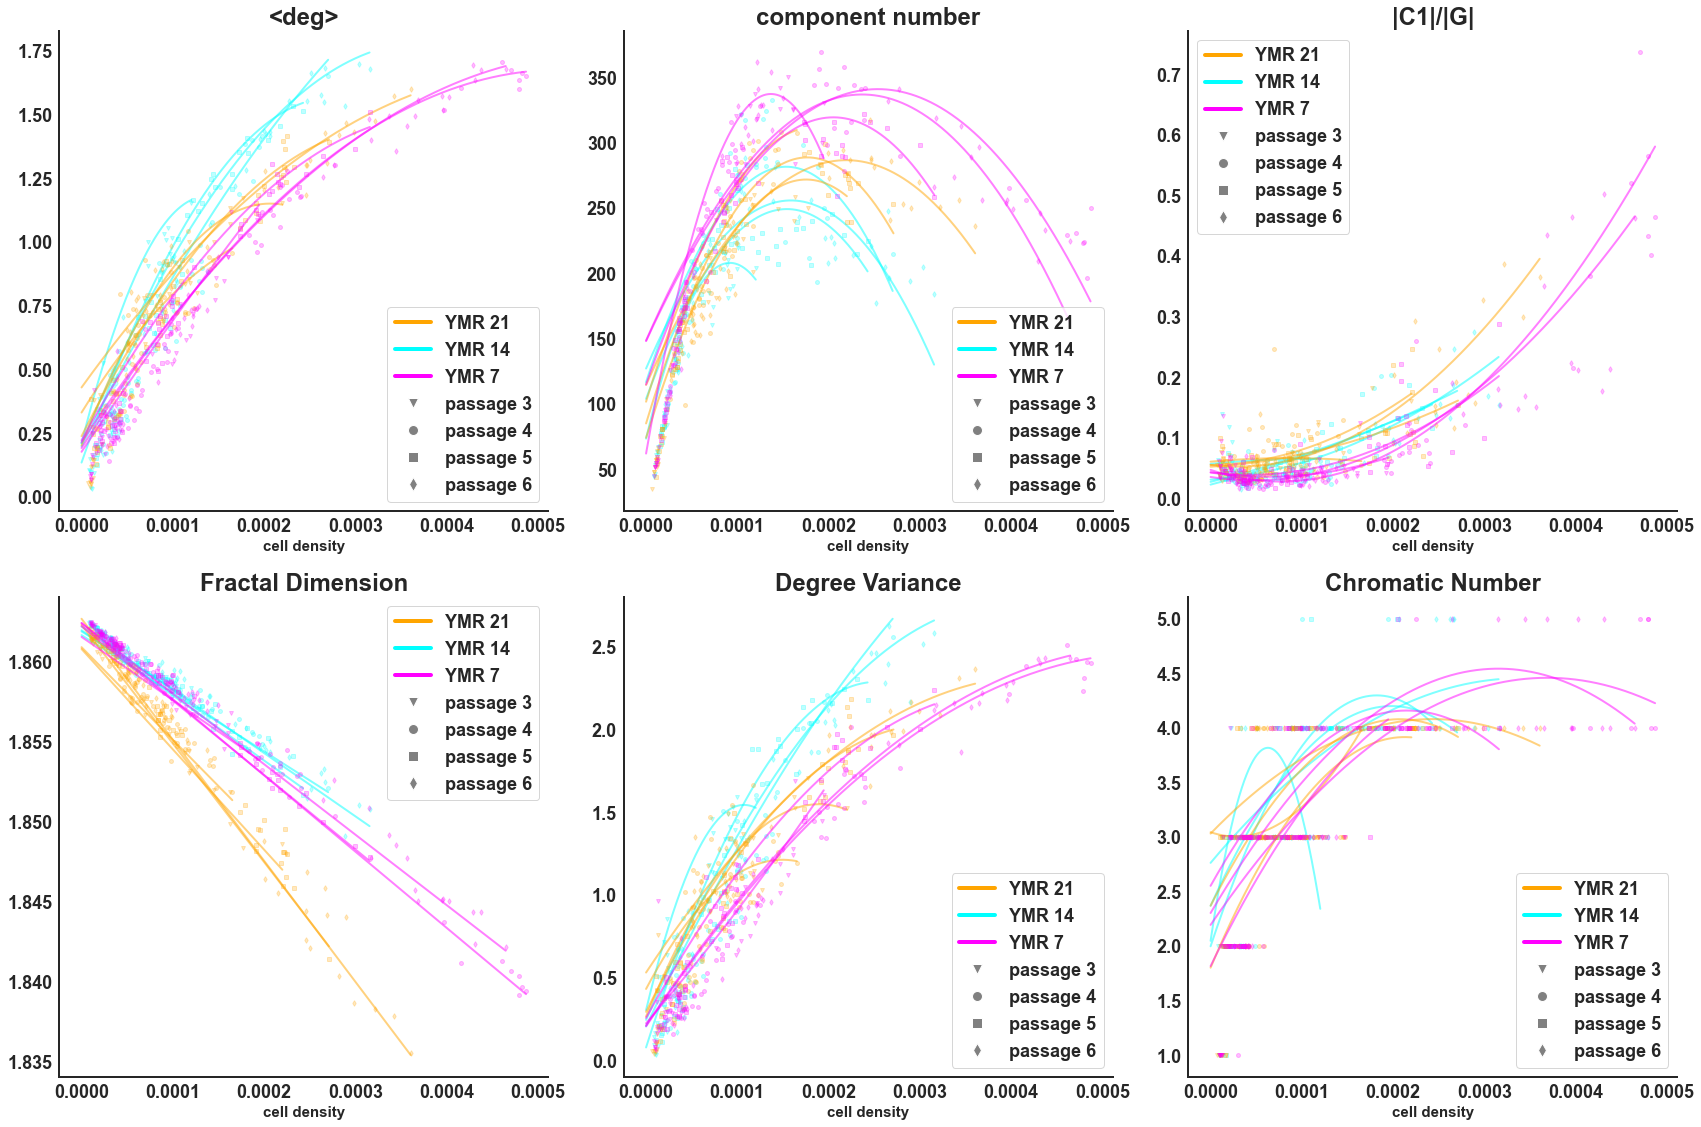

In [26]:
#//  NETWORK PROPS  //#

import itertools
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

plot = True

#if plot != False:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))
#symbols = ['.','x','+','^','s','>']
symbols = ['x']

#fitprops = []
ncomp0 = []
ncomp1 = []
ncomp2 = []
mdeg0 = []
mdeg1 = []
mdeg2 = []
mcompmass0 = []
mcompmass1 = []
mcompmass2 = []
fdim0 = []
fdim1 = []
cnum0 = []
cnum1 = []
cnum2 = []
degvar0 = []
degvar1 = []
degvar2 = []

ncomp0err = []
ncomp1err = []
ncomp2err = []
mdeg0err = []
mdeg1err = []
mdeg2err = []
mcompmass0err = []
mcompmass1err = []
mcompmass2err = []
fdim0err = []
fdim1err = []
cnum0err = []
cnum1err = []
cnum2err = []
degvar0err = []
degvar1err = []
degvar2err = []

temp = [0,0,0,0] #temporary
color = "c"
alpha = 1
symbol = "x"


# legend_elements = [ Line2D([0], [0], color='orange', lw=4, label='YM 13.3'),
#                    Line2D([0], [0], color='cyan', lw=4, label='YM 6.3'),
#                    Line2D([0], [0], color='magenta', lw=4, label='YM 5.3'),
# #                    Line2D([0], [0], marker='^', color='w', label='passage 2',markerfacecolor='gray', markersize=10),
#                    Line2D([0], [0], marker='v', color='w', label='passage 3',markerfacecolor='gray', markersize=10),
#                    Line2D([0], [0], marker='o', color='w', label='passage 4',markerfacecolor='gray', markersize=10),
#                    Line2D([0], [0], marker='s', color='w', label='passage 5',markerfacecolor='gray', markersize=10),
#                    Line2D([0], [0], marker='d', color='w', label='passage 6',markerfacecolor='gray', markersize=10)
#                   ]

legend_elements = [ Line2D([0], [0], color='orange', lw=4, label='YMR 21'),
                   Line2D([0], [0], color='cyan', lw=4, label='YMR 14'),
                   Line2D([0], [0], color='magenta', lw=4, label='YMR 7'),
#                    Line2D([0], [0], marker='^', color='w', label='passage 2',markerfacecolor='gray', markersize=10),
                   Line2D([0], [0], marker='v', color='w', label='passage 3',markerfacecolor='gray', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='passage 4',markerfacecolor='gray', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='passage 5',markerfacecolor='gray', markersize=10),
                   Line2D([0], [0], marker='d', color='w', label='passage 6',markerfacecolor='gray', markersize=10)
                  ]

# legend_elements = [ Line2D([0], [0], color='orange', lw=4, label='YMR 21'),
#                     Line2D([0], [0], color='cyan', lw=4, label='YMR 14'),
#                     Line2D([0], [0], color='magenta', lw=4, label='YMR 7'),]

#'''
def polyfit_rough(xdata,ydata,pdegree = 1, plot = False, axes = None, color = None, label = "Fit function", alpha = 0.2):
    
    #bins = np.linspace(min(xdata), max(xdata), num=10)
    bins = np.linspace(0, 0.0005 , num=20)
    x_binned = np.digitize(xdata, bins)
    
    #print(bins)
    #print(x_binned)
    
    meancalc = lambda ydata, x_binned, index: sum([ydata[i] for i in np.where(x_binned==index)[0]])/len([ydata[i] for i in np.where(x_binned==index)[0]])
    bin_y = [meancalc(ydata, x_binned, i) for i in np.unique(x_binned)]
    bin_x = [bins[i-1] for i in np.unique(x_binned)]

    popt = np.polyfit(bin_x, bin_y, pdegree, cov=True)#---------------------------------
    if plot != False:
        t = np.linspace(0, max(xdata), 1000)
        axes.plot(t, np.poly1d(popt[0])(t), label=label, color = color, linewidth = 2, alpha = alpha)
        # Hide the top and right spines of the axis
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.set_xlabel("cell density")
        axes.legend(handles=legend_elements)
    return popt[0],popt[1]
#'''
'''
def polyfit_rough(xdata,ydata,pdegree = 1, plot = False, axes = None, color = None, label = "Fit function", alpha = 0.2):
    popt = np.polyfit(xdata, ydata, pdegree)#---------------------------------
    if plot != False:
        t = np.linspace(0, max(xdata), 1000)
        axes.plot(t, np.poly1d(popt)(t), label=label, color = color, linewidth = .5, alpha = alpha)
        # Hide the top and right spines of the axis
        axes.spines['right'].set_visible(False)
        axes.spines['top'].set_visible(False)
        axes.set_xlabel("cell density")
        axes.legend(handles=legend_elements)
    return popt
'''

i = 0
ax1.set_title("<deg>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree = [network.average_degree() for network in lineage.items]

    degree = [degree for _,degree in sorted(zip(density,degree))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)
    ax1.plot(density,degree, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,degree,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    mdeg0.append(temp[0])
    mdeg1.append(temp[1])
    mdeg2.append(temp[2])
    mdeg0err.append(covariance[0][0])
    mdeg1err.append(covariance[1][1])
    mdeg2err.append(covariance[2][2])
    
    i += 1

i = 0
ax2.set_title("component number")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    num_components = [network.num_components for network in lineage.items]

    num_components = [num_components for _,num_components in sorted(zip(density,num_components))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)
    ax2.plot(density,num_components, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,num_components,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    ncomp0.append(temp[0])
    ncomp1.append(temp[1])
    ncomp2.append(temp[2])
    ncomp0err.append(covariance[0][0])
    ncomp1err.append(covariance[1][1])
    ncomp2err.append(covariance[2][2])
    i += 1

i = 0
ax3.set_title("|C1|/|G|")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    cellnum = [network.number for network in lineage.items]
    max_mass = [network.get_max_comp_mass() for network in lineage.items]

    max_mass = [max_mass for _,max_mass in sorted(zip(density,max_mass))]
    cellnum = sorted(cellnum)
    density = sorted(density)
    
    max_mass = np.divide(max_mass,cellnum)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax3.plot(density,max_mass, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,max_mass,pdegree=2,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    mcompmass0.append(temp[0])
    mcompmass1.append(temp[1])
    mcompmass2.append(temp[2])
    mcompmass0err.append(covariance[0][0])
    mcompmass1err.append(covariance[1][1])
    mcompmass2err.append(covariance[2][2])
    i += 1

i = 0
ax4.set_title("Fractal Dimension")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    fractal_dim = [network.fractal_dim for network in lineage.items]

    fractal_dim = [fractal_dim for _,fractal_dim in sorted(zip(density,fractal_dim))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax4.plot(density,fractal_dim, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,fractal_dim,pdegree=1,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    fdim0.append(temp[0])
    fdim1.append(temp[1])
    fdim0err.append(covariance[0][0])
    fdim1err.append(covariance[1][1])
    i += 1

i = 0
ax5.set_title("Degree Variance")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    degree_var = [network.degree_variance() for network in lineage.items]

    degree_var = [degree_var for _,degree_var in sorted(zip(density,degree_var))]
    density = sorted(density)
    
    #degree_var = np.divide(degree_var,density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax5.plot(density,degree_var, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,degree_var,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    degvar0.append(temp[0])
    degvar1.append(temp[1])
    degvar2.append(temp[2])
    degvar0err.append(covariance[0][0])
    degvar1err.append(covariance[1][1])
    degvar2err.append(covariance[2][2])
    i += 1

i = 0
ax6.set_title("Chromatic Number")
for lineage in lineage_list:
    #tqdm(lineage_list, desc = "chromatic number", position=0, leave=True):
    density = [network.density for network in lineage.items]
    colornum = [network.calc_chromatic() for network in lineage.items]

    colornum = [colornum for _,colornum in sorted(zip(density,colornum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax6.plot(density,colornum, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,colornum,pdegree=2,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    cnum0.append(temp[0])
    cnum1.append(temp[1])
    cnum2.append(temp[2])
    cnum0err.append(covariance[0][0])
    cnum1err.append(covariance[1][1])
    cnum2err.append(covariance[2][2])
    i += 1

plt.tight_layout()
plt.savefig("YMR_multiweek_NetworkPropertyPlots.png", format="png", dpi=300)
# plt.savefig("YM_multiweek_NetworkPropertyPlots.png", format="png", dpi=300)

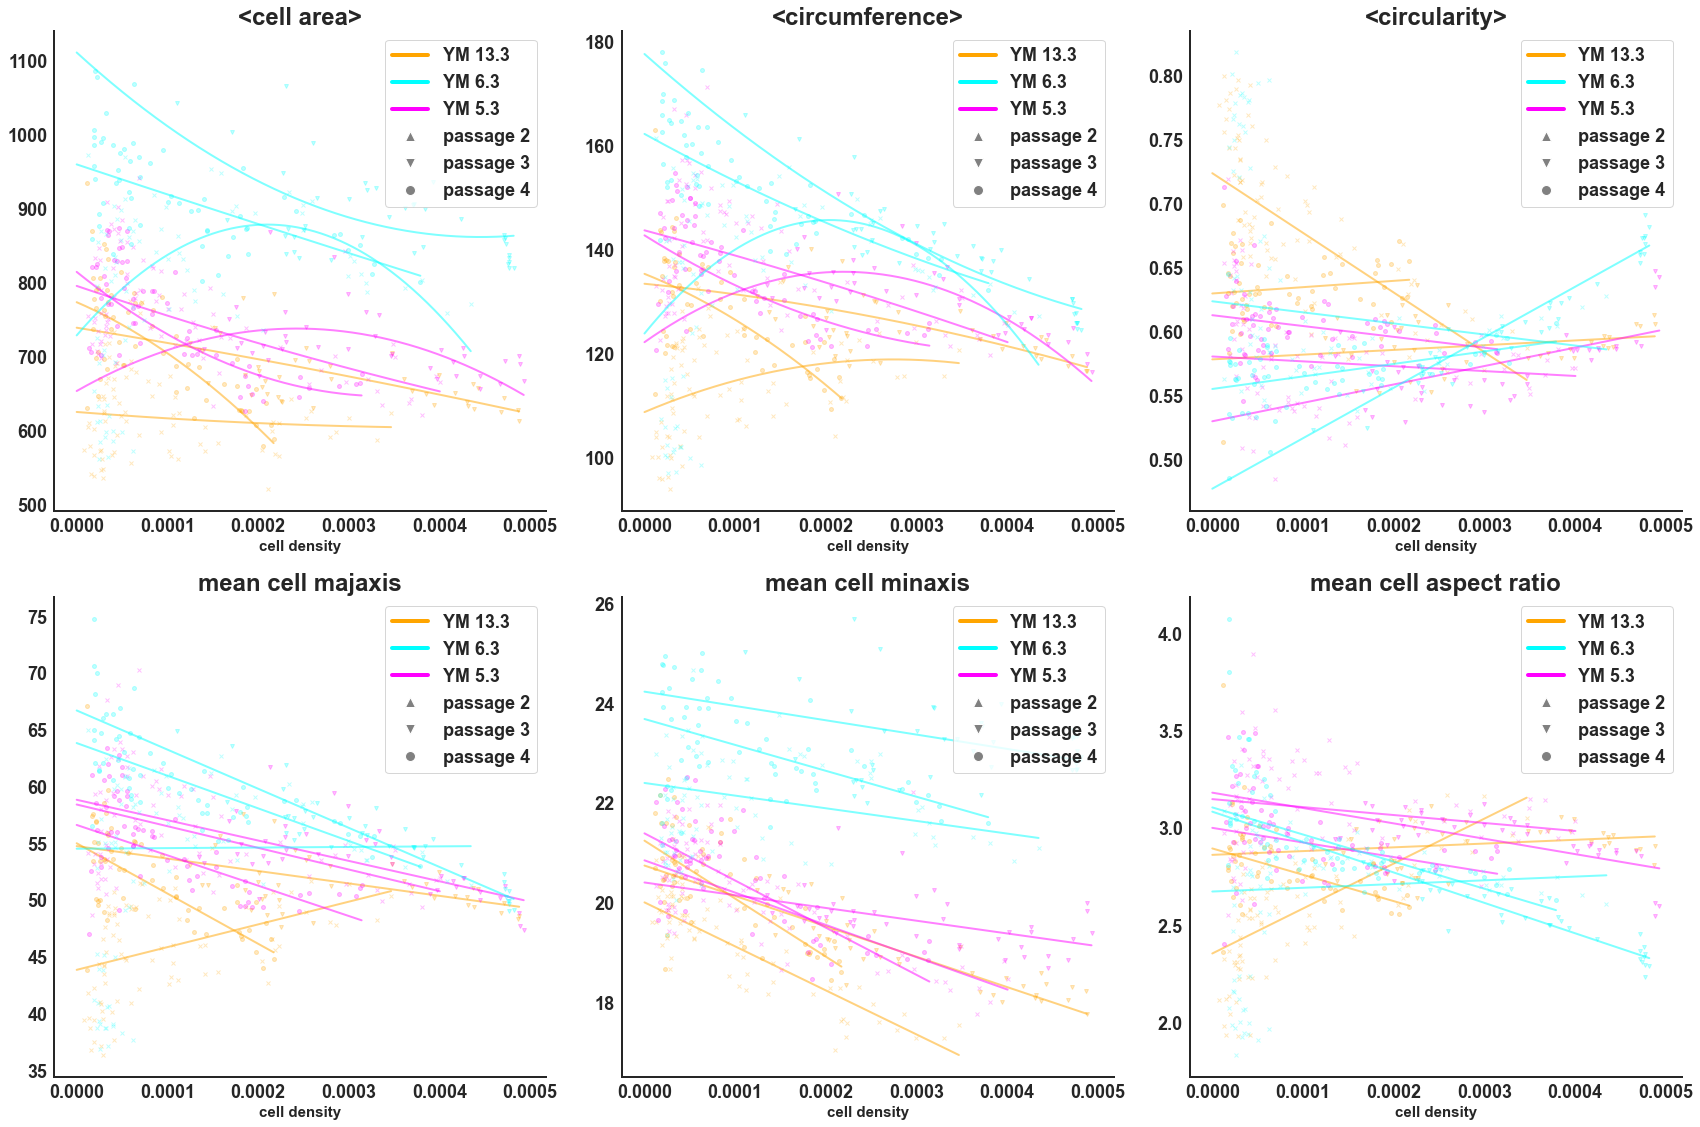

In [18]:
#//  SINGLE CELL PROPS  //#

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))

plot = True

#area_l = np.empty(0)
#area_h = np.empty(0)
area0 = np.empty(0)
area1 = np.empty(0)
area2 = np.empty(0)
#circum_l = np.empty(0)
#circum_h = np.empty(0)
circum0 = np.empty(0)
circum1 = np.empty(0)
circum2 = np.empty(0)
circ0 = np.empty(0)
circ1 = np.empty(0)
asra0 = np.empty(0)
asra1 = np.empty(0)

temp = [0,0,0,0] #temporary


#avg = lambda x: sum(x)/len(x)
def avg(x):
    if type(x) is list:
        return sum(x)/len(x)
    return x


i = 0
ax1.set_title("<cell area>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    area = [avg(network.cell_areas) for network in lineage.items]

    area = [area for _,area in sorted(zip(density,area))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax1.plot(density,area, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,area,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    area0 = np.append(area0,temp[0])
    area1 = np.append(area1,temp[1])
    area2 = np.append(area2,temp[2])
    i += 1

i = 0
ax2.set_title("<circumference>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circum = [avg(network.cell_perimeters) for network in lineage.items]

    circum = [circum for _,circum in sorted(zip(density,circum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax2.plot(density,circum, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circum,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circum0 = np.append(circum0,temp[0])
    circum1 = np.append(circum1,temp[1])
    circum2 = np.append(circum2,temp[2])
    i += 1

i = 0
ax3.set_title("<circularity>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circul = [avg(network.cell_circularities) for network in lineage.items]

    circul = [circul for _,circul in sorted(zip(density,circul))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax3.plot(density,circul, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circul,pdegree=1,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circ0 = np.append(circ0,temp[0])
    circ1 = np.append(circ1,temp[1])
    i += 1

i = 0
ax4.set_title("mean cell majaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    majax = [avg(network.cell_majaxes) for network in lineage.items]

    majax = [majax for _,majax in sorted(zip(density,majax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax4.plot(density,majax, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,majax,pdegree=1,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax5.set_title("mean cell minaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    minax = [avg(network.cell_minaxes) for network in lineage.items]

    minax = [minax for _,minax in sorted(zip(density,minax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax5.plot(density,minax, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,minax,pdegree=1,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax6.set_title("mean cell aspect ratio")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    asra = [avg(network.asra) for network in lineage.items]
    asra = [asra for _,asra in sorted(zip(density,asra))]

    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax6.plot(density,asra, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,asra,pdegree=1,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    asra0 = np.append(asra0,temp[0])
    asra1 = np.append(asra1,temp[1])
    np.append(asra1,temp[1])
    i += 1

plt.tight_layout()
# plt.savefig("YMR_multiweek_SingleCellProps.png", dpi = 300)
# plt.savefig("YM_multiweek_SingleCellProps.png", dpi = 300)

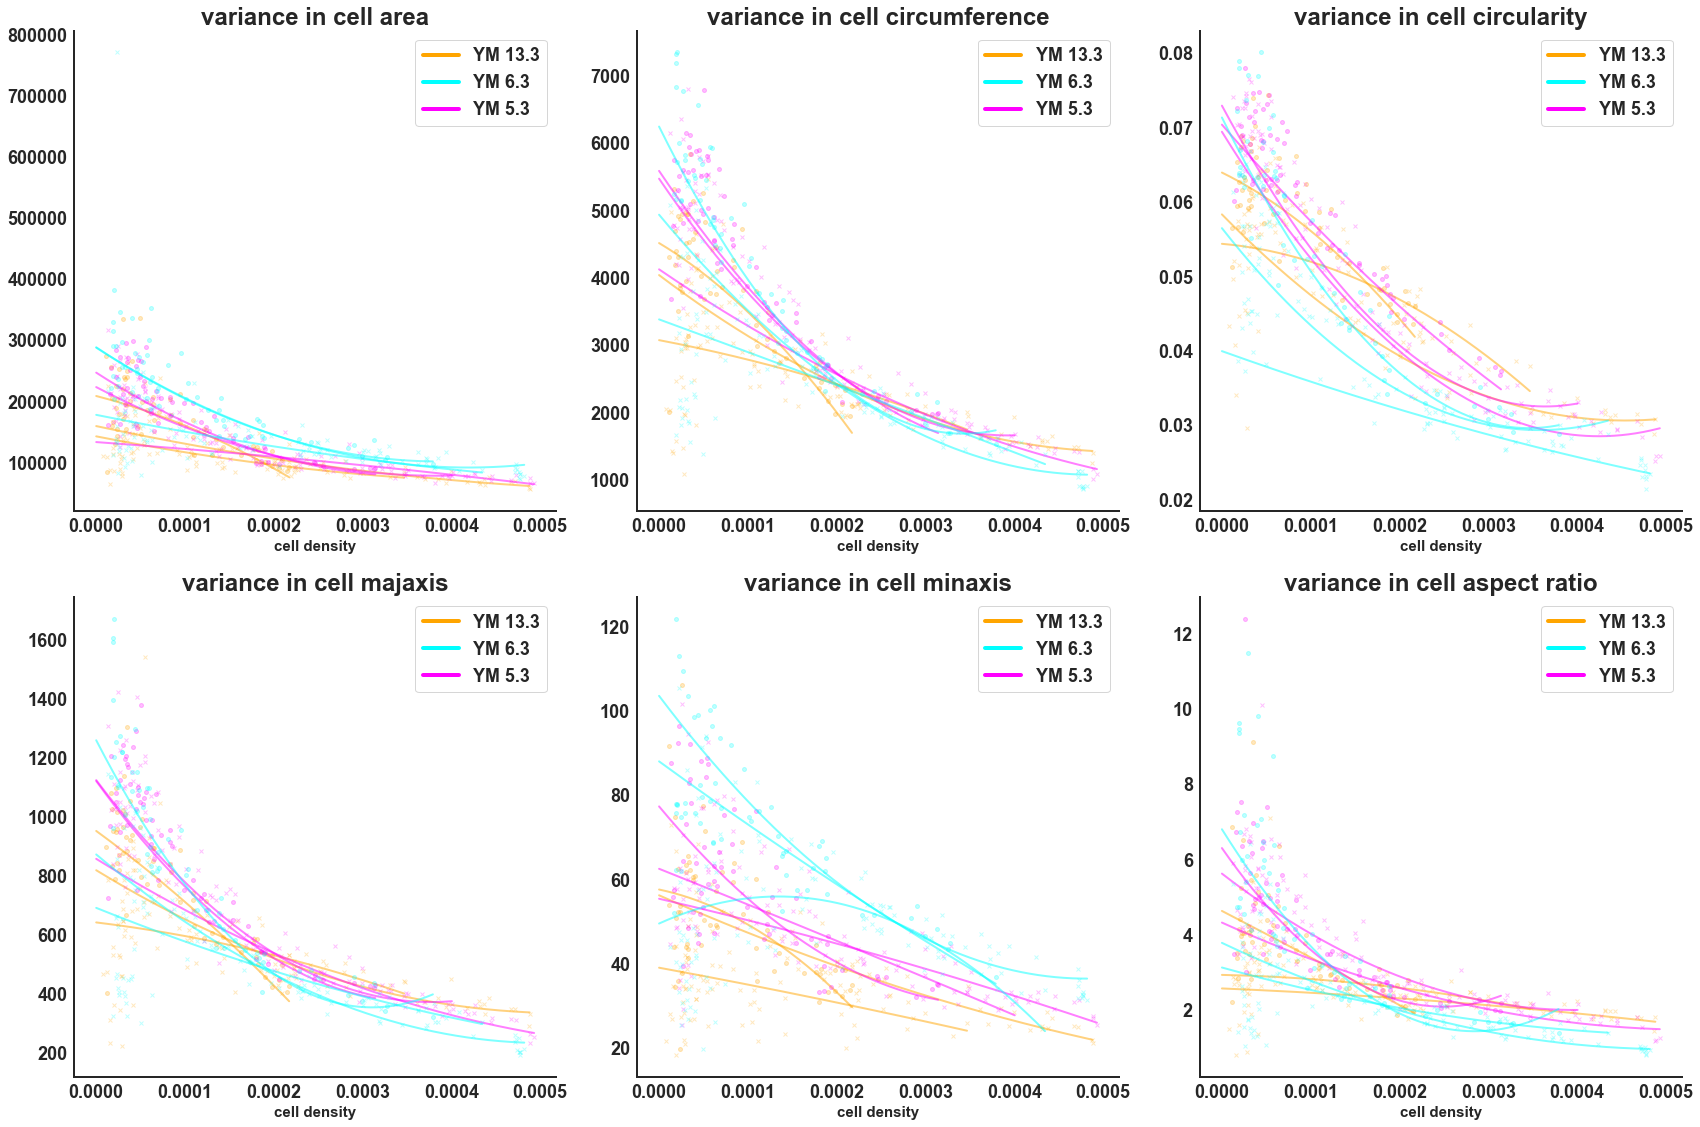

In [168]:
#//  SINGLE CELL VARIANCE PROPS  //#

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(24, 16))

plot = True

areavar0 = np.empty(0)
areavar1 = np.empty(0)
areavar2 = np.empty(0)
circumvar0 = np.empty(0)
circumvar1 = np.empty(0)
circumvar2 = np.empty(0)
circvar0 = np.empty(0)
circvar1 = np.empty(0)
circvar2 = np.empty(0)
asravar0 = np.empty(0)
asravar1 = np.empty(0)
asravar2 = np.empty(0)

temp = [0,0,0,0] #temporary


#avg = lambda x: sum(x)/len(x)
def avg(x):
    if type(x) is list:
        return sum(x)/len(x)
    return x


i = 0
ax1.set_title("variance in cell area")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    area = [avg(network.cell_areas_var) for network in lineage.items]

    area = [area for _,area in sorted(zip(density,area))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax1.plot(density,area, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,area,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    areavar0 = np.append(areavar0,temp[0])
    areavar1 = np.append(areavar1,temp[1])
    areavar2 = np.append(areavar2,temp[2])
    i += 1

i = 0
ax2.set_title("variance in cell circumference")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circum = [avg(network.cell_perimeters_var) for network in lineage.items]

    circum = [circum for _,circum in sorted(zip(density,circum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax2.plot(density,circum, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circum,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circumvar0 = np.append(circumvar0,temp[0])
    circumvar1 = np.append(circumvar1,temp[1])
    circumvar2 = np.append(circumvar2,temp[2])
    i += 1

i = 0
ax3.set_title("variance in cell circularity")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circul = [avg(network.cell_circularities_var) for network in lineage.items]

    circul = [circul for _,circul in sorted(zip(density,circul))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax3.plot(density,circul, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circul,pdegree=2,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    circvar0 = np.append(circvar0,temp[0])
    circvar1 = np.append(circvar1,temp[1])
    circvar2 = np.append(circvar2,temp[2])
    i += 1

i = 0
ax4.set_title("variance in cell majaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    majax = [avg(network.cell_majaxes_var) for network in lineage.items]

    majax = [majax for _,majax in sorted(zip(density,majax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax4.plot(density,majax, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,majax,pdegree=2,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax5.set_title("variance in cell minaxis")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    minax = [avg(network.cell_minaxes_var) for network in lineage.items]

    minax = [minax for _,minax in sorted(zip(density,minax))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax5.plot(density,minax, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,minax,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax6.set_title("variance in cell aspect ratio")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    asra = [avg(network.asra_var) for network in lineage.items]
    asra = [asra for _,asra in sorted(zip(density,asra))]

    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax6.plot(density,asra, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,asra,pdegree=2,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    asravar0 = np.append(asravar0,temp[0])
    asravar1 = np.append(asravar1,temp[1])
    asravar2 = np.append(asravar2,temp[2])
    np.append(asra1,temp[1])
    i += 1

plt.tight_layout()
# plt.savefig("YMR_multiweek_SingleCellPropsVariance.png", dpi = 300)
plt.savefig("YM_multiweek_SingleCellPropsVariance.png", dpi = 300)

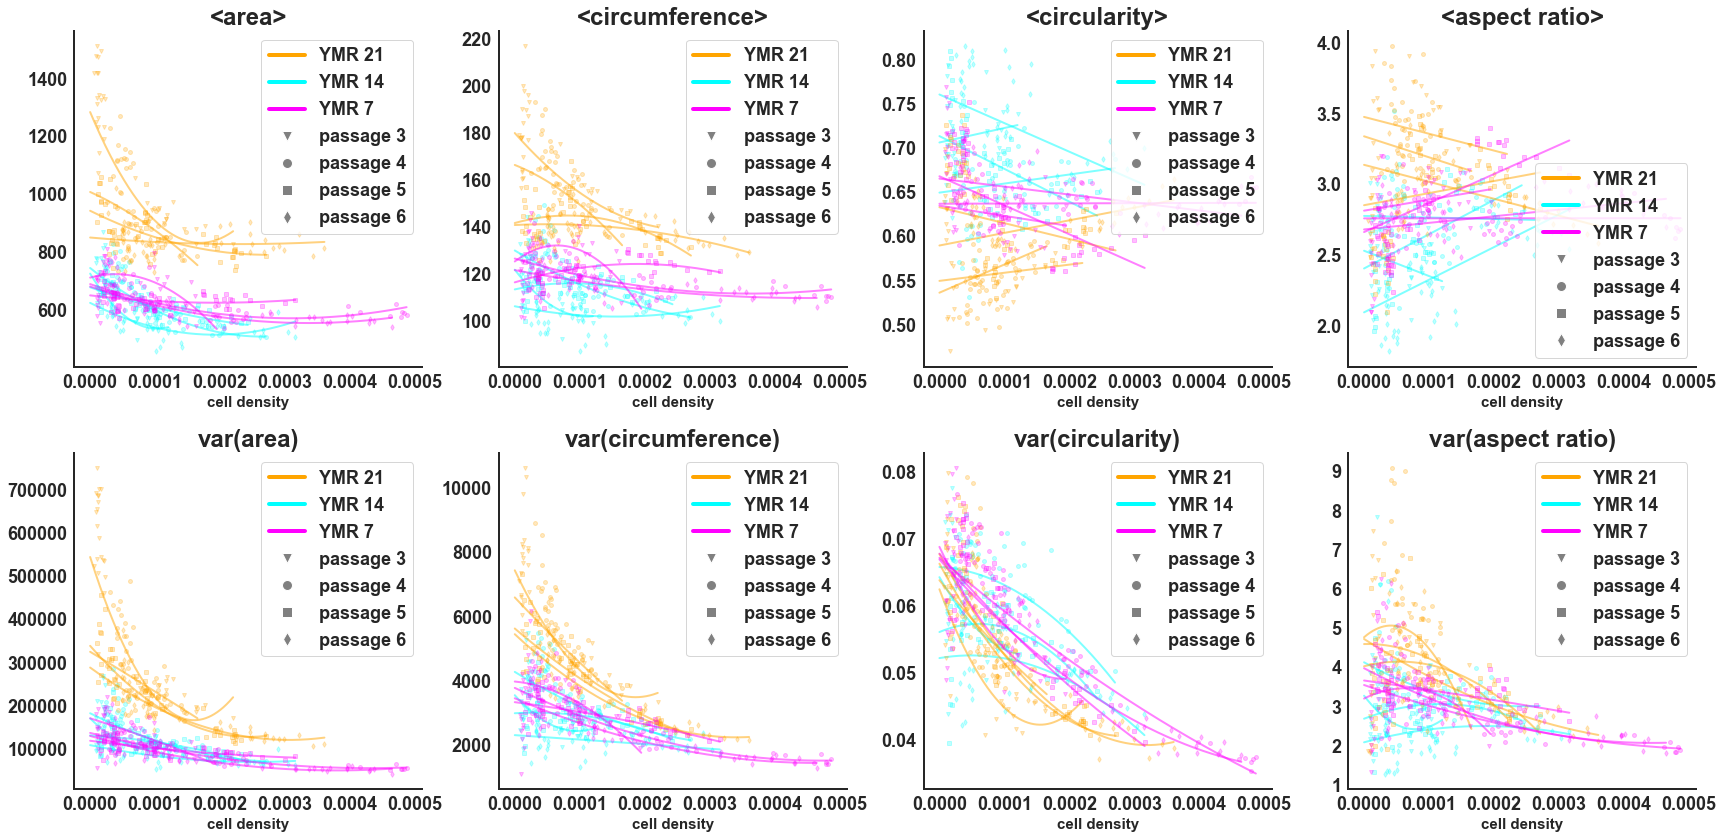

In [28]:
#//  SINGLE CELL PROPS *PLOTTING* //#

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 12))

plot = True

symbols = ['x']

#area_l = np.empty(0)
#area_h = np.empty(0)
#area0 = np.empty(0)
#area1 = np.empty(0)
#area2 = np.empty(0)
#circum_l = np.empty(0)
#circum_h = np.empty(0)
#circum0 = np.empty(0)
#circum1 = np.empty(0)
#circum2 = np.empty(0)
#circ0 = np.empty(0)
#circ1 = np.empty(0)
#asra0 = np.empty(0)
#asra1 = np.empty(0)

temp = [0,0,0,0] #temporary


#avg = lambda x: sum(x)/len(x)
def avg(x):
    if type(x) is list:
        return sum(x)/len(x)
    return x


i = 0
ax1.set_title("<area>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    area = [avg(network.cell_areas) for network in lineage.items]

    area = [area for _,area in sorted(zip(density,area))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax1.plot(density,area, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,area,pdegree=2,axes = ax1, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax2.set_title("<circumference>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circum = [avg(network.cell_perimeters) for network in lineage.items]

    circum = [circum for _,circum in sorted(zip(density,circum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax2.plot(density,circum, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circum,pdegree=2,axes = ax2, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax3.set_title("<circularity>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circul = [avg(network.cell_circularities) for network in lineage.items]

    circul = [circul for _,circul in sorted(zip(density,circul))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax3.plot(density,circul, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circul,pdegree=1,axes = ax3, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax4.set_title("<aspect ratio>")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    asra = [avg(network.asra) for network in lineage.items]
    asra = [asra for _,asra in sorted(zip(density,asra))]

    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax4.plot(density,asra, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,asra,pdegree=1,axes = ax4, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    np.append(asra1,temp[1])
    i += 1
    
    
    
i = 0
ax5.set_title("var(area)")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    area = [avg(network.cell_areas_var) for network in lineage.items]

    area = [area for _,area in sorted(zip(density,area))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax5.plot(density,area, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,area,pdegree=2,axes = ax5, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax6.set_title("var(circumference)")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circum = [avg(network.cell_perimeters_var) for network in lineage.items]

    circum = [circum for _,circum in sorted(zip(density,circum))]
    density = sorted(density)
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax6.plot(density,circum, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circum,pdegree=2,axes = ax6, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax7.set_title("var(circularity)")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    circul = [avg(network.cell_circularities_var) for network in lineage.items]

    circul = [circul for _,circul in sorted(zip(density,circul))]
    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax7.plot(density,circul, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,circul,pdegree=2,axes = ax7, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    i += 1

i = 0
ax8.set_title("var(aspect ratio)")
for lineage in lineage_list:
    density = [network.density for network in lineage.items]
    
    asra = [avg(network.asra_var) for network in lineage.items]
    asra = [asra for _,asra in sorted(zip(density,asra))]

    density = sorted(density)
    
    #color=next(ax1._get_lines.prop_cycler)['color']
    color, alpha, symbol = color_picker(lineage.tag)

    ax8.plot(density,asra, symbol, label = lineage.tag, color = color, alpha = alpha/2)
    
    temp,covariance = polyfit_rough(density,asra,pdegree=2,axes = ax8, color = color, label = lineage.tag, plot = plot, alpha = alpha)
    np.append(asra1,temp[1])
    i += 1
    
plt.tight_layout()
plt.savefig("YMR_multiweek_CellMorphologyPlots.png", dpi=300)
# plt.savefig("YM_multiweek_CellMorphologyPlots.png", dpi=300)

In [170]:
#///   LOAD TO PANDAS DF   ///#


'''
each lineage has:

lineage

3 fit params for num components:
    ncomp0 ncomp1 ncomp2
    
2 fit params for mean degree (normalized):
    mdeg0 mdeg1
    
3 fit params for max comp mass (normalized):
    mcompmass0 mcompmass1 mcompmass2
    
2 fit params for fractal dimension:
    fdim0 fdim1
    
2 fit params for chromatic number:
    cnum0 cnum1
    
2 fit params for degree variance:
    degvar0 degvar1
    
'''

#Creating the dataframe

l_tags = [lineage.tag for lineage in lineage_list]


objs = {
    'lineage':l_tags,
    'ncomp0':ncomp0,
    'ncomp1':ncomp1, 
    'ncomp2':ncomp2, 
    'mdeg0':mdeg0, 
    'mdeg1':mdeg1, 
    'mcompmass0':mcompmass0, 
    'mcompmass1':mcompmass1, 
    'mcompmass2':mcompmass2, 
    'fdim0':fdim0, 
    'fdim1':fdim1, 
    'cnum0':cnum0, 
    'cnum1':cnum1, 
    'degvar0':degvar0, 
    'degvar1':degvar1,
}

'''
Additional OBJS:
'''
ncomp0 = np.array(ncomp0)
ncomp1 = np.array(ncomp1)
ncomp2 = np.array(ncomp2)
mdeg0 = np.array(mdeg0)
mdeg1 = np.array(mdeg1)
mdeg2 = np.array(mdeg2)
mcompmass0 = np.array(mcompmass0)
mcompmass1 = np.array(mcompmass1)
mcompmass2 = np.array(mcompmass2)
fdim0 = np.array(fdim0)
cnum0 = np.array(cnum0)
cnum1 = np.array(cnum1)
cnum2 = np.array(cnum2)

#area_l = []
#area_h = []
#circum_l = []
#circum_h = []
#circ0
#circ1
#asra0
#asra1

hdensity = 0.0004
ldensity = 0.00015

#cell area low density, high density:
area_l = area0*ldensity*ldensity+area1*ldensity+area2
area_h = area0*hdensity*hdensity+area1*hdensity+area2

#cell circumference low density, high density:
circum_l = circum0*ldensity*ldensity+circum1*ldensity+circum2
circum_h = circum0*hdensity*hdensity+circum1*hdensity+circum2

#num components apex:
ncomph = -ncomp1/(2*ncomp0)                       #x coord of vertex
ncompk = ncomp2 - (ncomp1*ncomp1/(4*ncomp0))      #y coord of vertex

#(relative) max component mass:
mcompmass_h = mcompmass0*(hdensity*hdensity)+mcompmass1*(hdensity)+mcompmass2  #y value calculated at x=0.0004
mcompmass_d = 2*mcompmass0*(hdensity)+mcompmass1                           #y' value calculated at x=0.0004
    
#fractal dimension:
fdim0  #slope only, constant not needed as all converge to same value with very few objects
    
#mean degree / degree variance:
  #as K-degree and variance in degree are highly correlated, and likely simply scale linearly, here omit degvar
mdeg_l = mdeg0*(ldensity*ldensity)+mdeg1*(ldensity)+mdeg2  #y value calculated at x=0.00015
dmdeg_l = 2*mdeg0*(ldensity)+mdeg1                      #y' value calculated at x=0.0004
mdeg_h = mdeg0*(hdensity*hdensity)+mdeg1*(hdensity)+mdeg2     #y value calculated at x=0.00015
dmdeg_h = 2*mdeg0*(hdensity)+mdeg1                       #y' value calculated at x=0.0004
    
#chromatic number:
cnumh = -cnum1/(2*cnum0)                    #x coord of vertex
cnumk = cnum2 - (cnum1*cnum1/(4*cnum0))     #y coord of vertex

#for single cell morphological variance, all properties are calculated at density of 0.0001
areavar = areavar0*(0.0001*0.0001)+areavar1*0.0001+areavar2
circumvar = circumvar0*(0.0001*0.0001)+circumvar1*0.0001+circumvar2
circvar = circvar0*(0.0001*0.0001)+circvar1*0.0001+circvar2
asravar = asravar0*(0.0001*0.0001)+asravar1*0.0001+asravar2

add_objs = {
    #network properties
    'lineage':l_tags,
    'ncomph':ncomph,
    'ncompk':ncompk, 
    'mdeg_l':mdeg_l, 
    'dmdeg_l':dmdeg_l,
    'mdeg_h':mdeg_h, 
    'dmdeg_h':dmdeg_h,
    'mcompmass_h':mcompmass_h, 
    'mcompmass_d':mcompmass_d, 
    'fdim0':fdim0, 
    'cnumh':cnumh, 
    'cnumk':cnumk, 
    #cell properties
    'area_l':area_l,
    'area_h':area_h,
    'circum_l':circum_l,
    'circum_h':circum_h,
    'circ0':circ0,
    'circ1':circ1,
    'asra0':asra0,
    'asra1':asra1,
    #cell variance properties
    'areavar':areavar,
    'circumvar':circumvar,
    'circvar':circvar,
    'asravar':asravar,
}

#df = pd.DataFrame(objs)
df = pd.DataFrame(add_objs)

In [171]:
df

,lineage,ncomph,ncompk,mdeg_l,dmdeg_l,mdeg_h,dmdeg_h,mcompmass_h,mcompmass_d,fdim0,...,circum_l,circum_h,circ0,circ1,asra0,asra1,areavar,circumvar,circvar,asravar
0,13.3 p2,0.000204,468.816877,0.637118,3532.707221,1.467634,3111.419834,0.346499,2468.501075,-44.901700,...,116.830711,116.780258,-465.472128,0.723445,2307.402817,2.354386,116325.042122,2779.346462,0.051925,2.810829
1,13.3 p3,0.000135,488.569312,0.553348,4029.536480,1.353661,2372.970107,0.213995,1705.344253,-52.423795,...,130.156091,121.454618,36.894359,0.578126,193.351360,2.860739,130264.125892,3131.019704,0.047426,2.447222
2,13.3 p4,0.000202,515.647517,0.554527,3404.700077,1.589860,4877.957823,0.065666,316.155417,-43.339756,...,120.731455,77.815992,49.257727,0.629554,-1351.998383,2.893760,159875.466622,3486.687158,0.056064,3.384063
3,5.3 p2,0.000229,429.612262,0.696108,3470.822351,1.288125,1265.317740,0.171899,605.115764,-52.342090,...,136.306474,122.248146,-37.993577,0.580374,-408.294175,3.146969,157277.928285,3771.341067,0.053737,4.017093
4,5.3 p3,0.000123,482.821293,0.568132,3678.318910,1.263237,1882.519829,0.182895,1876.070329,-60.329619,...,134.378472,126.606331,143.661820,0.529798,-788.330873,3.180153,121717.581717,3280.588059,0.052373,3.343619
5,5.3 p4,0.000206,482.886615,0.611875,3260.385946,1.313958,2356.281059,0.123698,666.450182,-49.742115,...,129.362579,120.304455,-84.436201,0.612603,-749.758584,2.999413,165776.179644,3853.992730,0.057360,3.586135
6,6.3 p2,0.000227,389.507333,0.754612,2930.035476,1.388256,2139.116068,0.436903,2753.742845,-72.506480,...,144.139029,125.611490,-86.401103,0.623476,191.752954,2.672533,149961.012782,2891.442506,0.043366,2.521750
7,6.3 p3,0.000197,421.638174,0.632564,2889.510841,1.266230,2179.818932,0.287629,2617.228916,-87.668845,...,156.828618,133.303215,393.840609,0.477172,-1560.396773,3.082571,205026.725324,3510.308453,0.035798,2.764617
8,6.3 p4,0.000213,442.086808,0.641590,3253.648424,1.307108,2070.495899,0.200631,996.894062,-74.304134,...,149.023615,132.428615,97.708465,0.555024,-1391.813784,3.104521,203847.218791,3967.550663,0.050637,3.682250


In [104]:
# #plotting properties over multiple passages

# #print(df)
# fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 12))

# #lineage7 = df.lo
# lin7 = []
# lin7.append(df.loc[df['lineage'] == "7/3"].values.tolist()[0])
# lin7.append(df.loc[df['lineage'] == "7/4"].values.tolist()[0])
# lin7.append(df.loc[df['lineage'] == "7/5"].values.tolist()[0])
# lin7.append(df.loc[df['lineage'] == "7/6"].values.tolist()[0])

# lin14 = []
# lin14.append(df.loc[df['lineage'] == "14/3"].values.tolist()[0])
# lin14.append(df.loc[df['lineage'] == "14/4"].values.tolist()[0])
# lin14.append(df.loc[df['lineage'] == "14/5"].values.tolist()[0])
# lin14.append(df.loc[df['lineage'] == "14/6"].values.tolist()[0])

# lin21 = []
# lin21.append(df.loc[df['lineage'] == "21/3"].values.tolist()[0])
# lin21.append(df.loc[df['lineage'] == "21/4"].values.tolist()[0])
# lin21.append(df.loc[df['lineage'] == "21/5"].values.tolist()[0])
# lin21.append(df.loc[df['lineage'] == "21/6"].values.tolist()[0])

# x = [3,4,5,6]

# linlist = [lin7,lin14,lin21]
# for lin in linlist:
#     t1 = [traits[1] for traits in lin]
#     ax1.plot(x,t1)
#     t2 = [traits[2] for traits in lin]
#     ax2.plot(x,t2)
#     t3 = [traits[3] for traits in lin]
#     ax3.plot(x,t3)
#     t4 = [traits[4] for traits in lin]
#     ax4.plot(x,t4)
#     t5 = [traits[5] for traits in lin]
#     ax5.plot(x,t5)
#     t6 = [traits[6] for traits in lin]
#     ax6.plot(x,t6)
#     t7 = [traits[7] for traits in lin]
#     ax7.plot(x,t7)
#     t9 = [traits[9] for traits in lin]
#     ax8.plot(x,t9)

In [200]:
del(lineage_list)

In [105]:
#///   PCA   ///#

#Property Standardization

'''features = ['ncomp0', 'ncomp1', 'ncomp2', 
           'mdeg0', 'mdeg1', 
           'mcompmass0', 'mcompmass1', 'mcompmass2', 
           'fdim0', 'fdim1', 
           'cnum0', 'cnum1', 
           'degvar0', 'degvar1']
'''

features =  ['ncomph', 'ncompk', 'mdeg_l', 
    'dmdeg_l','mdeg_h', 'dmdeg_h',
    'mcompmass_h', 'mcompmass_d', 'fdim0', 
    'cnumh', 'cnumk', 
    'area_l', 'area_h',
    'circum_l', 'circum_h',
    'circ0', 'circ1',
    'asra0', 'asra1']

x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
x = StandardScaler().fit_transform(x)

#PCA Projection

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2', 'pc3',])# 'pc4', 'pc5', 'pc6', 'pc7'])

finalDf = pd.concat([principalDf, df[['lineage']]], axis = 1)

EVR = pca.explained_variance_ratio_

print(EVR)
print(sum(EVR))

[0.48773379 0.25264781 0.15039657]
0.8907781712802231


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


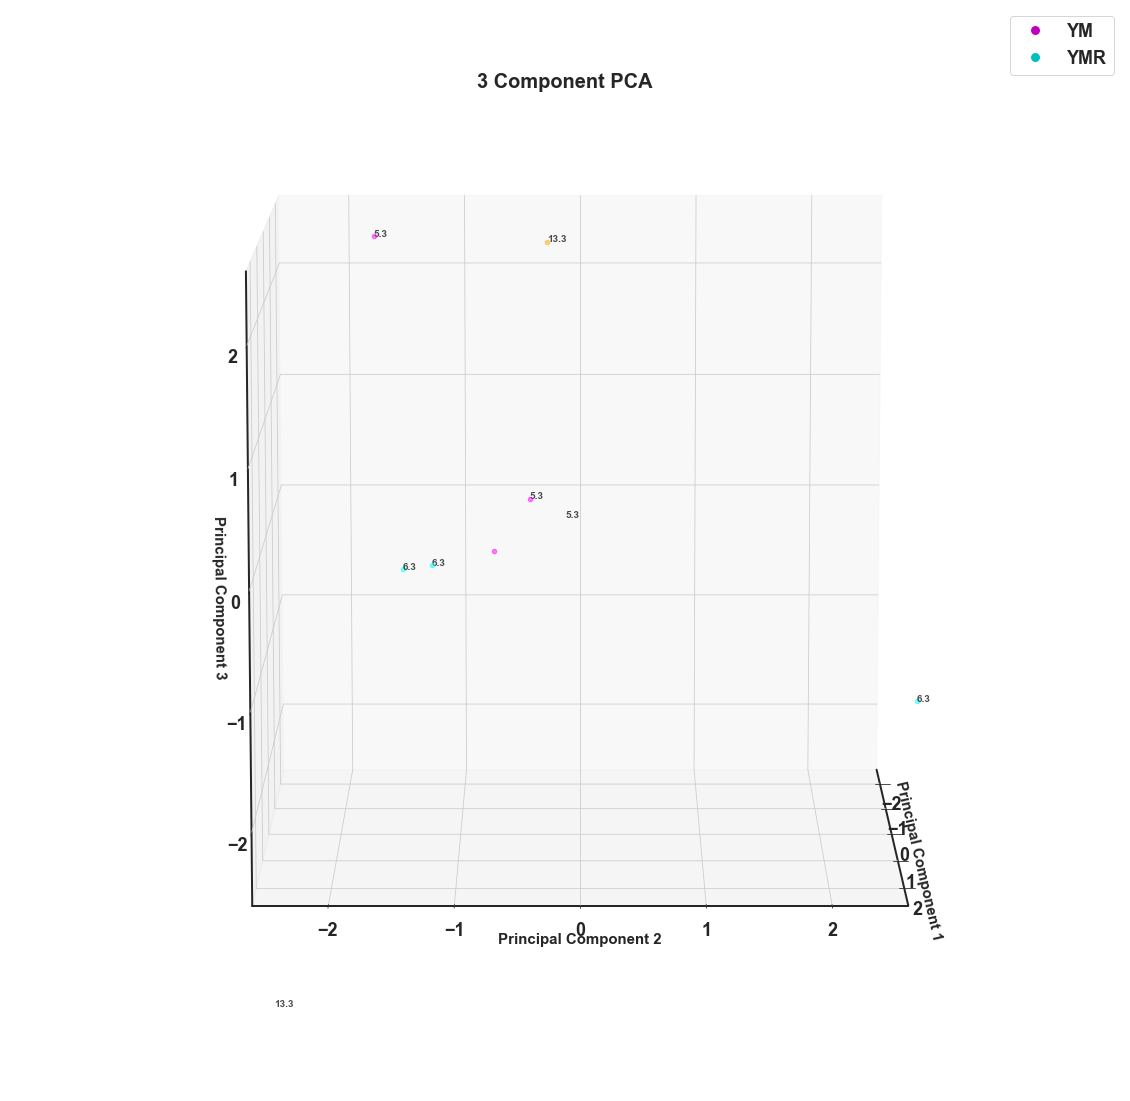

In [106]:


#Visualizer

#fig, ax1 = plt.subplots(1, 1, figsize=(30, 8))
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_zlabel('Principal Component 3', fontsize = 15)
ax1.set_title('3 Component PCA', fontsize = 20)

ax1.axes.set_xlim3d(left=-2.5, right=2.5) 
ax1.axes.set_ylim3d(bottom=-2.5, top=2.5) 
ax1.axes.set_zlim3d(bottom=-2.5, top=2.5) 


symbols = ['.','x','+','^','o',]

for i in range(len(finalDf)):
    indicesToKeep = finalDf['lineage'] == lineage
    #color=next(ax6._get_lines.prop_cycler)['color']

    color, alpha, symbol = color_picker(finalDf.at[i, 'lineage'])

    ax1.scatter3D(finalDf.at[i, 'pc1']
          , finalDf.at[i, 'pc2']
          , finalDf.at[i, 'pc3']
          , symbols[i%5], color = color
          , alpha = 0.5)
    ax1.text(finalDf.at[i, 'pc1'],finalDf.at[i, 'pc2'],finalDf.at[i, 'pc3'] ,  finalDf.at[i,'lineage'], size=10, alpha = 0.7,  color='k') 

    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='YM',
                          markerfacecolor='m', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='YMR',
                          markerfacecolor='c', markersize=10),]
ax1.legend(handles=legend_elements)
    
    
    
for ii in tqdm(range(0,360,360)):
    ax1.view_init(elev=10., azim=ii)
    plt.savefig("movie_pca/movie%d.png" % ii)

#plt.savefig("2 Component PCA.png", dpi = 75)

In [172]:
#///   UMAP   ///#

import umap

#FOR out dimensionality
n_components = 2

reducer = umap.UMAP(n_components = n_components)

#Property Standardization

'''features = ['ncomp0', 'ncomp1', 'ncomp2', 
           'mdeg0', 'mdeg1', 
           'mcompmass0', 'mcompmass1', 'mcompmass2', 
           'fdim0', 'fdim1', 
           'cnum0', 'cnum1', 
           'degvar0', 'degvar1']
'''
features =  ['ncomph', 'ncompk', 'mdeg_l', 
    'dmdeg_l','mdeg_h', 'dmdeg_h',
    'mcompmass_h', 'mcompmass_d', 'fdim0', 
    'cnumh', 'cnumk', ]

x = df.loc[:, features].values
y = df.loc[:,['lineage']].values
#df['line'] = [color_picker(lineage[0]) for lineage in y]
x = StandardScaler().fit_transform(x)

embedding = reducer.fit_transform(x)
embedding.shape

/Users/trevorchan/environments/machine-learning/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


(9, 2)

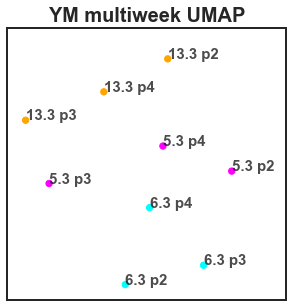

In [180]:
if n_components == 2:
    fig = plt.figure(figsize=(5, 5))
    ax1 = fig.add_subplot(111)

#     ax1.set_title('YMR multiweek UMAP', fontsize=20)
    ax1.set_title('YM multiweek UMAP', fontsize=20)

    ax1.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=[color_picker(lineage[0])[0] for lineage in y],
        s=40)
    for i in range(len(embedding)):
        ax1.text(embedding[i][0],embedding[i][1], df['lineage'][i], size=15, alpha = 0.7,  color='k') 
#     ax1.set_xticks([])
#     ax1.set_yticks([])
#     ax1.set_xlim(6.5,10.1)
#     ax1.set_ylim(-2.2,.8)
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlim(19.3,21.9)
    ax1.set_ylim(-4.7,-1.5)
    
#     plt.savefig("YMR_multiweek_umap_2D.png")
    plt.savefig("YM_multiweek_umap_2D.png")
    
if n_components == 3:
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')

    ax1.set_xlabel('umap 1', fontsize = 20)
    ax1.set_ylabel('umap 2', fontsize = 20)
    ax1.set_zlabel('umap 3', fontsize = 20)
    ax1.set_title('UMAP projection', fontsize=20)

    ax1.scatter(
        embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
        c=[color_picker(lineage[0])[0] for lineage in y])
    for i in range(len(embedding)):
        ax1.text(embedding[i][0],embedding[i][1],embedding[i][2], df['lineage'][i], size=10, alpha = 0.7,  color='k') 
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='YM',
                          markerfacecolor='r', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='YMR',
                          markerfacecolor='b', markersize=20),]
    ax1.legend(handles=legend_elements)
    
    for ii in tqdm(range(0,360,1)):
        ax1.view_init(elev=10., azim=ii)
        plt.savefig("movie_umap/movie%d.png" % ii)

In [116]:
#CLUSTERING PCA with OPTICS
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

pca_outs = np.array([[finalDf.at[i, 'pc1'], finalDf.at[i, 'pc2'], finalDf.at[i, 'pc3'], finalDf.at[i,'pc4']] for i in range(len(finalDf))])
X = pca_outs

clust = OPTICS(min_samples=9, xi=.0001, min_cluster_size=.03)

clust.fit(X)


space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10,10))
G = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(G[0, 0])
ax2 = plt.subplot(G[0, 1])
ax3 = plt.subplot(G[1:, :])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Automatic Clustering\nOPTICS')
ax3.axes.set_xlim([-1.5,1.5])
ax3.axes.set_ylim([-1.5,1.5])

plt.tight_layout()
plt.savefig("OPTICS_clustering.png")
plt.show()

KeyError: 'pc4'

[]


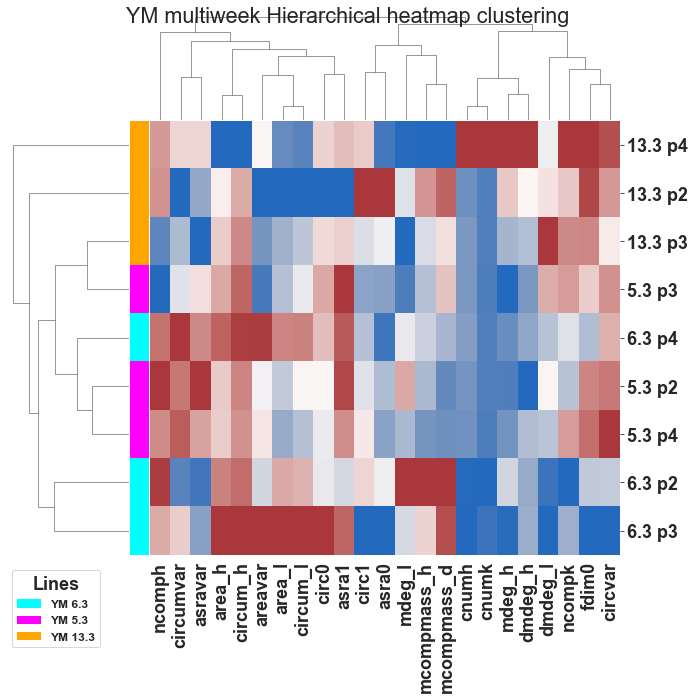

In [179]:
#Hierarchical heatmap clustering:
#Outlier exclusion based on Z-Score Thresholding:

from scipy import stats
#sns.set_theme(color_codes=False)
sns.color_palette("coolwarm", as_cmap=True)

#testdf = df.copy(deep=True)
testdf = df.copy(deep=True)

lineages = testdf.pop('lineage')
#testdf.pop('line')
z = np.abs(stats.zscore(testdf))

threshold = 4
dropindices = list(dict.fromkeys(np.where(z>threshold)[0].tolist()))
#dropindices = dropindices + [108,125,128,6] #added lineages manually checked and discarded
print(dropindices)
testdf = testdf.drop(dropindices)
lineages = lineages.drop(dropindices)
row_colors = [color_picker(lineage[0])[0] for lineage in df.loc[:,['lineage']].values]
dropindices.sort(reverse=True)
for index in dropindices:
    del row_colors[index]

g = sns.clustermap(testdf,standard_scale=1,row_colors=row_colors, xticklabels=True,  
                   figsize = (10,10), cmap="vlag",yticklabels=lineages,)
g.cax.set_visible(False)

# labeler = lambda label : 'YMR pre14' if label=='cyan' else ('YMR pre7' if label=='magenta' else 'YMR pre21')
labeler = lambda label : 'YM 6.3' if label=='cyan' else ('YM 5.3' if label=='magenta' else 'YM 13.3')
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.20, -4.5),prop={'size': 12})

# plt.title("YMR multiweek Hierarchical heatmap clustering",loc="left")
# g.fig.suptitle("YMR multiweek Hierarchical heatmap clustering")
g.fig.suptitle("YM multiweek Hierarchical heatmap clustering")


# plt.savefig("YMR_multiweek_hh_clustering.png", dpi=300)
plt.savefig("YM_multiweek_hh_clustering.png", dpi=300)



[13, 27, 32, 48, 51, 68, 142, 108, 125, 128, 6]


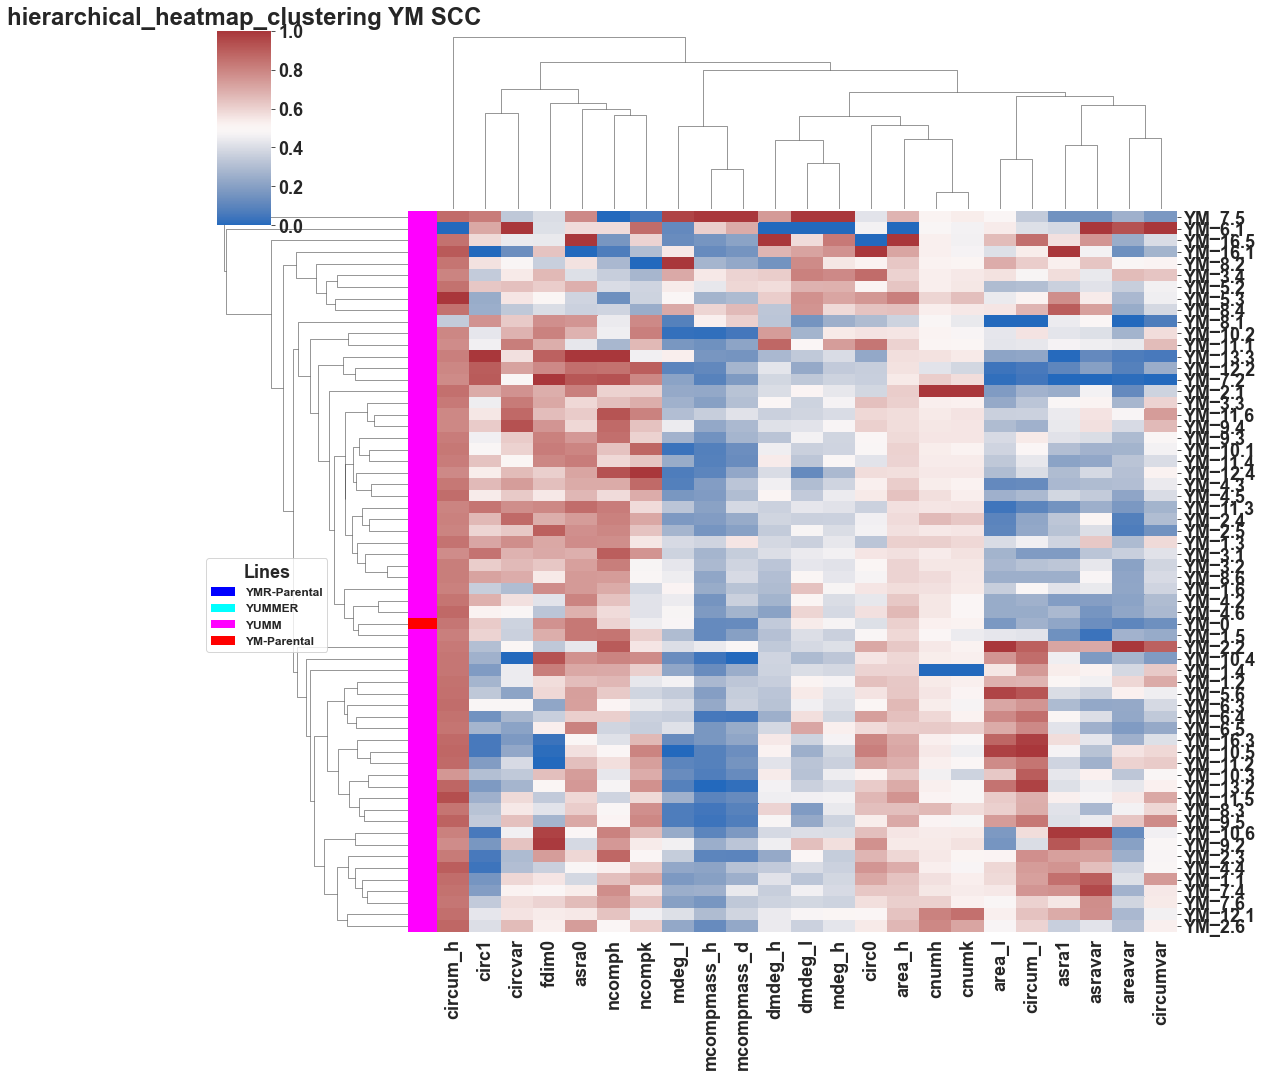

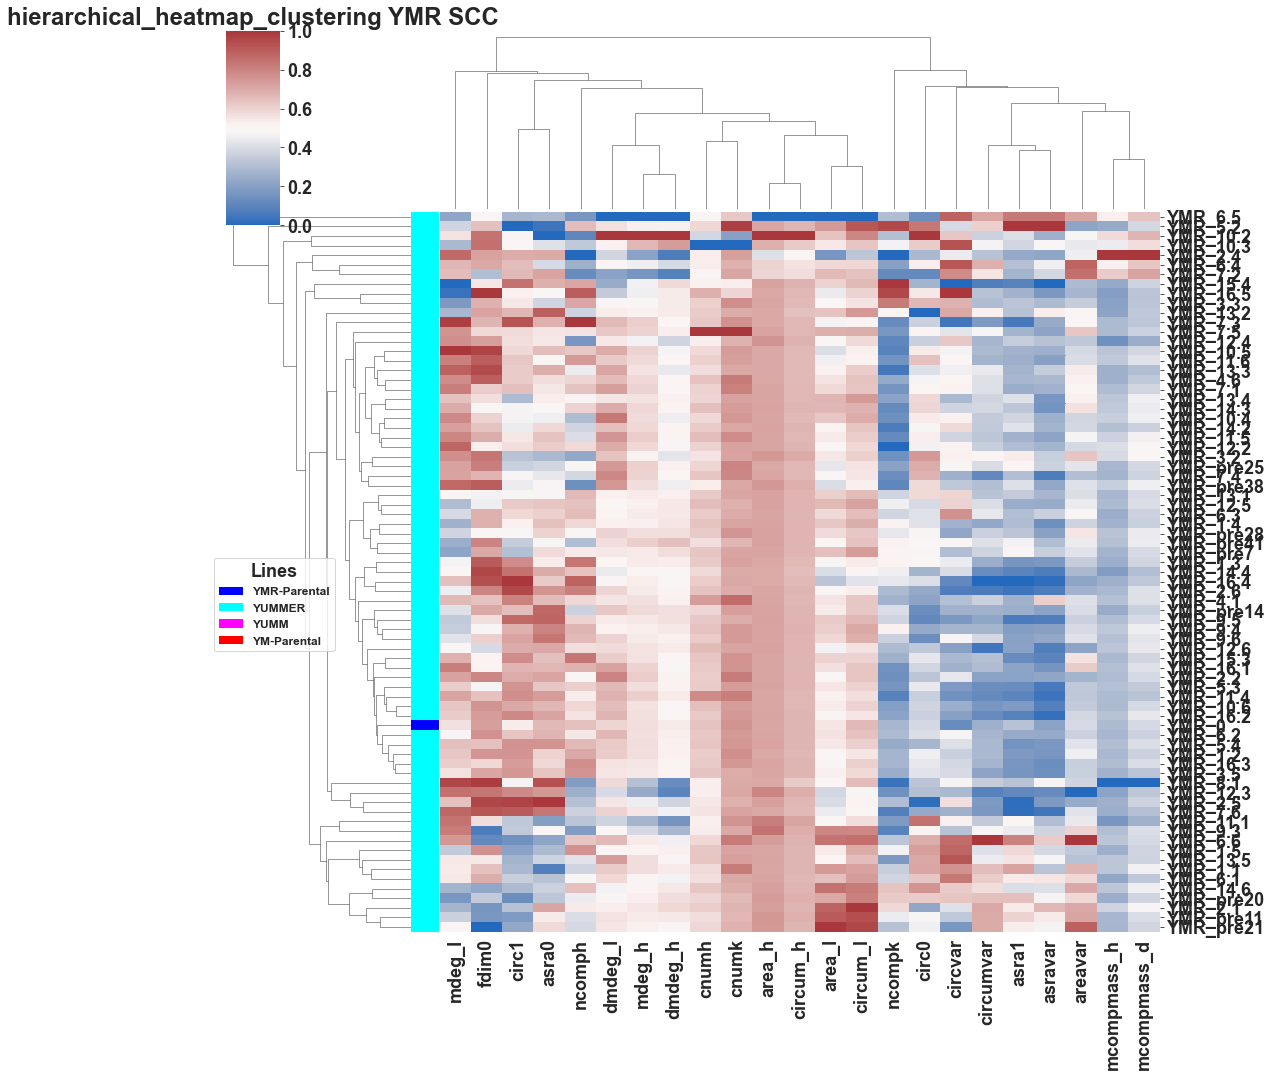

In [27]:
testdf = df.copy(deep=True)

testdf = df.copy(deep=True)

lineages = testdf.pop('lineage')
#testdf.pop('line')
z = np.abs(stats.zscore(testdf))

threshold = 4
dropindices = list(dict.fromkeys(np.where(z>threshold)[0].tolist()))
dropindices = dropindices + [108,125,128,6] #added lineages manually checked and discarded
print(dropindices)
testdf = testdf.drop(dropindices)
lineages = lineages.drop(dropindices)
row_colors = [color_picker(lineage[0])[0] for lineage in y]
dropindices.sort(reverse=True)
for index in dropindices:
    del row_colors[index]
    
testdf = testdf.reset_index(drop=True)
lineages = lineages.reset_index(drop=True)

YM_indexlist = [i for i in range(len(testdf)) if "YM_" in lineages[i]]
YMR_indexlist = [i for i in range(len(testdf)) if "YMR_" in lineages[i]]

ym_tester = testdf.iloc[YM_indexlist]
ym_lineages = lineages.iloc[YM_indexlist]
ym_colors = [row_colors[i] for i in YM_indexlist]

ymr_tester = testdf.iloc[YMR_indexlist]
ymr_lineages = lineages.iloc[YMR_indexlist]
ymr_colors = [row_colors[i] for i in YMR_indexlist]


g = sns.clustermap(ym_tester,standard_scale=1,row_colors=ym_colors, xticklabels=True,  
                   figsize = (15,15), cmap="vlag",yticklabels=ym_lineages,)

labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='red' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -2.2),prop={'size': 12})
plt.title("hierarchical_heatmap_clustering YM SCC")
plt.savefig("hierarchical_heatmap_clustering_YM.svg",format="svg")


g = sns.clustermap(ymr_tester,standard_scale=1,row_colors=ymr_colors, xticklabels=True,  
                   figsize = (15,15), cmap="vlag",yticklabels=ymr_lineages,)

labeler = lambda label : 'YUMMER' if label=='cyan' or label=='navy' else ('YUMM' if label=='magenta' 
                        else ('YMR-Parental' if label=='blue' else('YM-Parental' if label=='red' else 'k')))
for label in np.unique(np.array(row_colors)):
    g.ax_col_dendrogram.bar(0, 0, color=label, label=labeler(label), linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Lines', loc="center", ncol=1,
            bbox_to_anchor=(-0.23, -2.2),prop={'size': 12})
plt.title("hierarchical_heatmap_clustering YMR SCC")
plt.savefig("hierarchical_heatmap_clustering_YMR.svg",format="svg")

In [38]:
newdf = df.copy(deep=True)
newdf = newdf.drop(dropindices)
newdf.to_csv('SCC_data_vars.csv', index=True)
del(newdf)
newdf = finalDf.copy(deep=True)
newdf = newdf.drop(dropindices)
newdf.to_csv('SCC_data_pca.csv', index=True)
del(newdf)

In [18]:
df.to_csv(path_or_buf = "df_out.csv")

In [190]:
lineages[0]

'YMR_0'

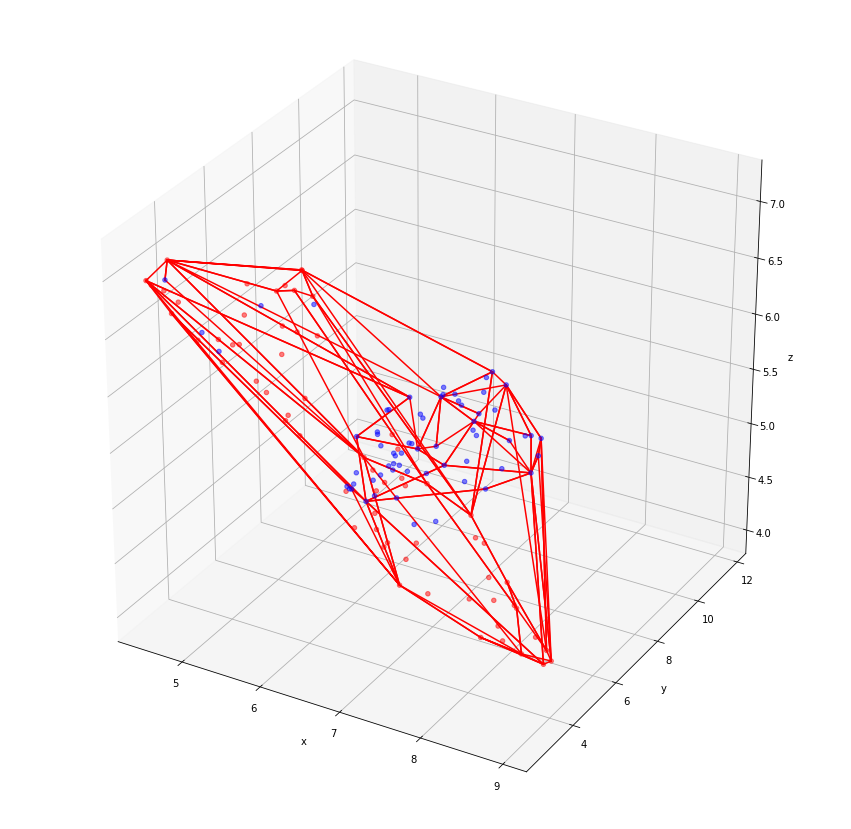

In [60]:
#TRY - TEMP

from scipy.spatial import ConvexHull
hull = ConvexHull(embedding)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

edges= zip(*embedding)

for i in hull.simplices:
    plt.plot(embedding[i,0], embedding[i,1], embedding[i,2], 'r-')

ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        embedding[:, 2],
        c=[choose_color(lineage[0]) for lineage in y],
        alpha = 0.5) 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

KeyError: 'line'

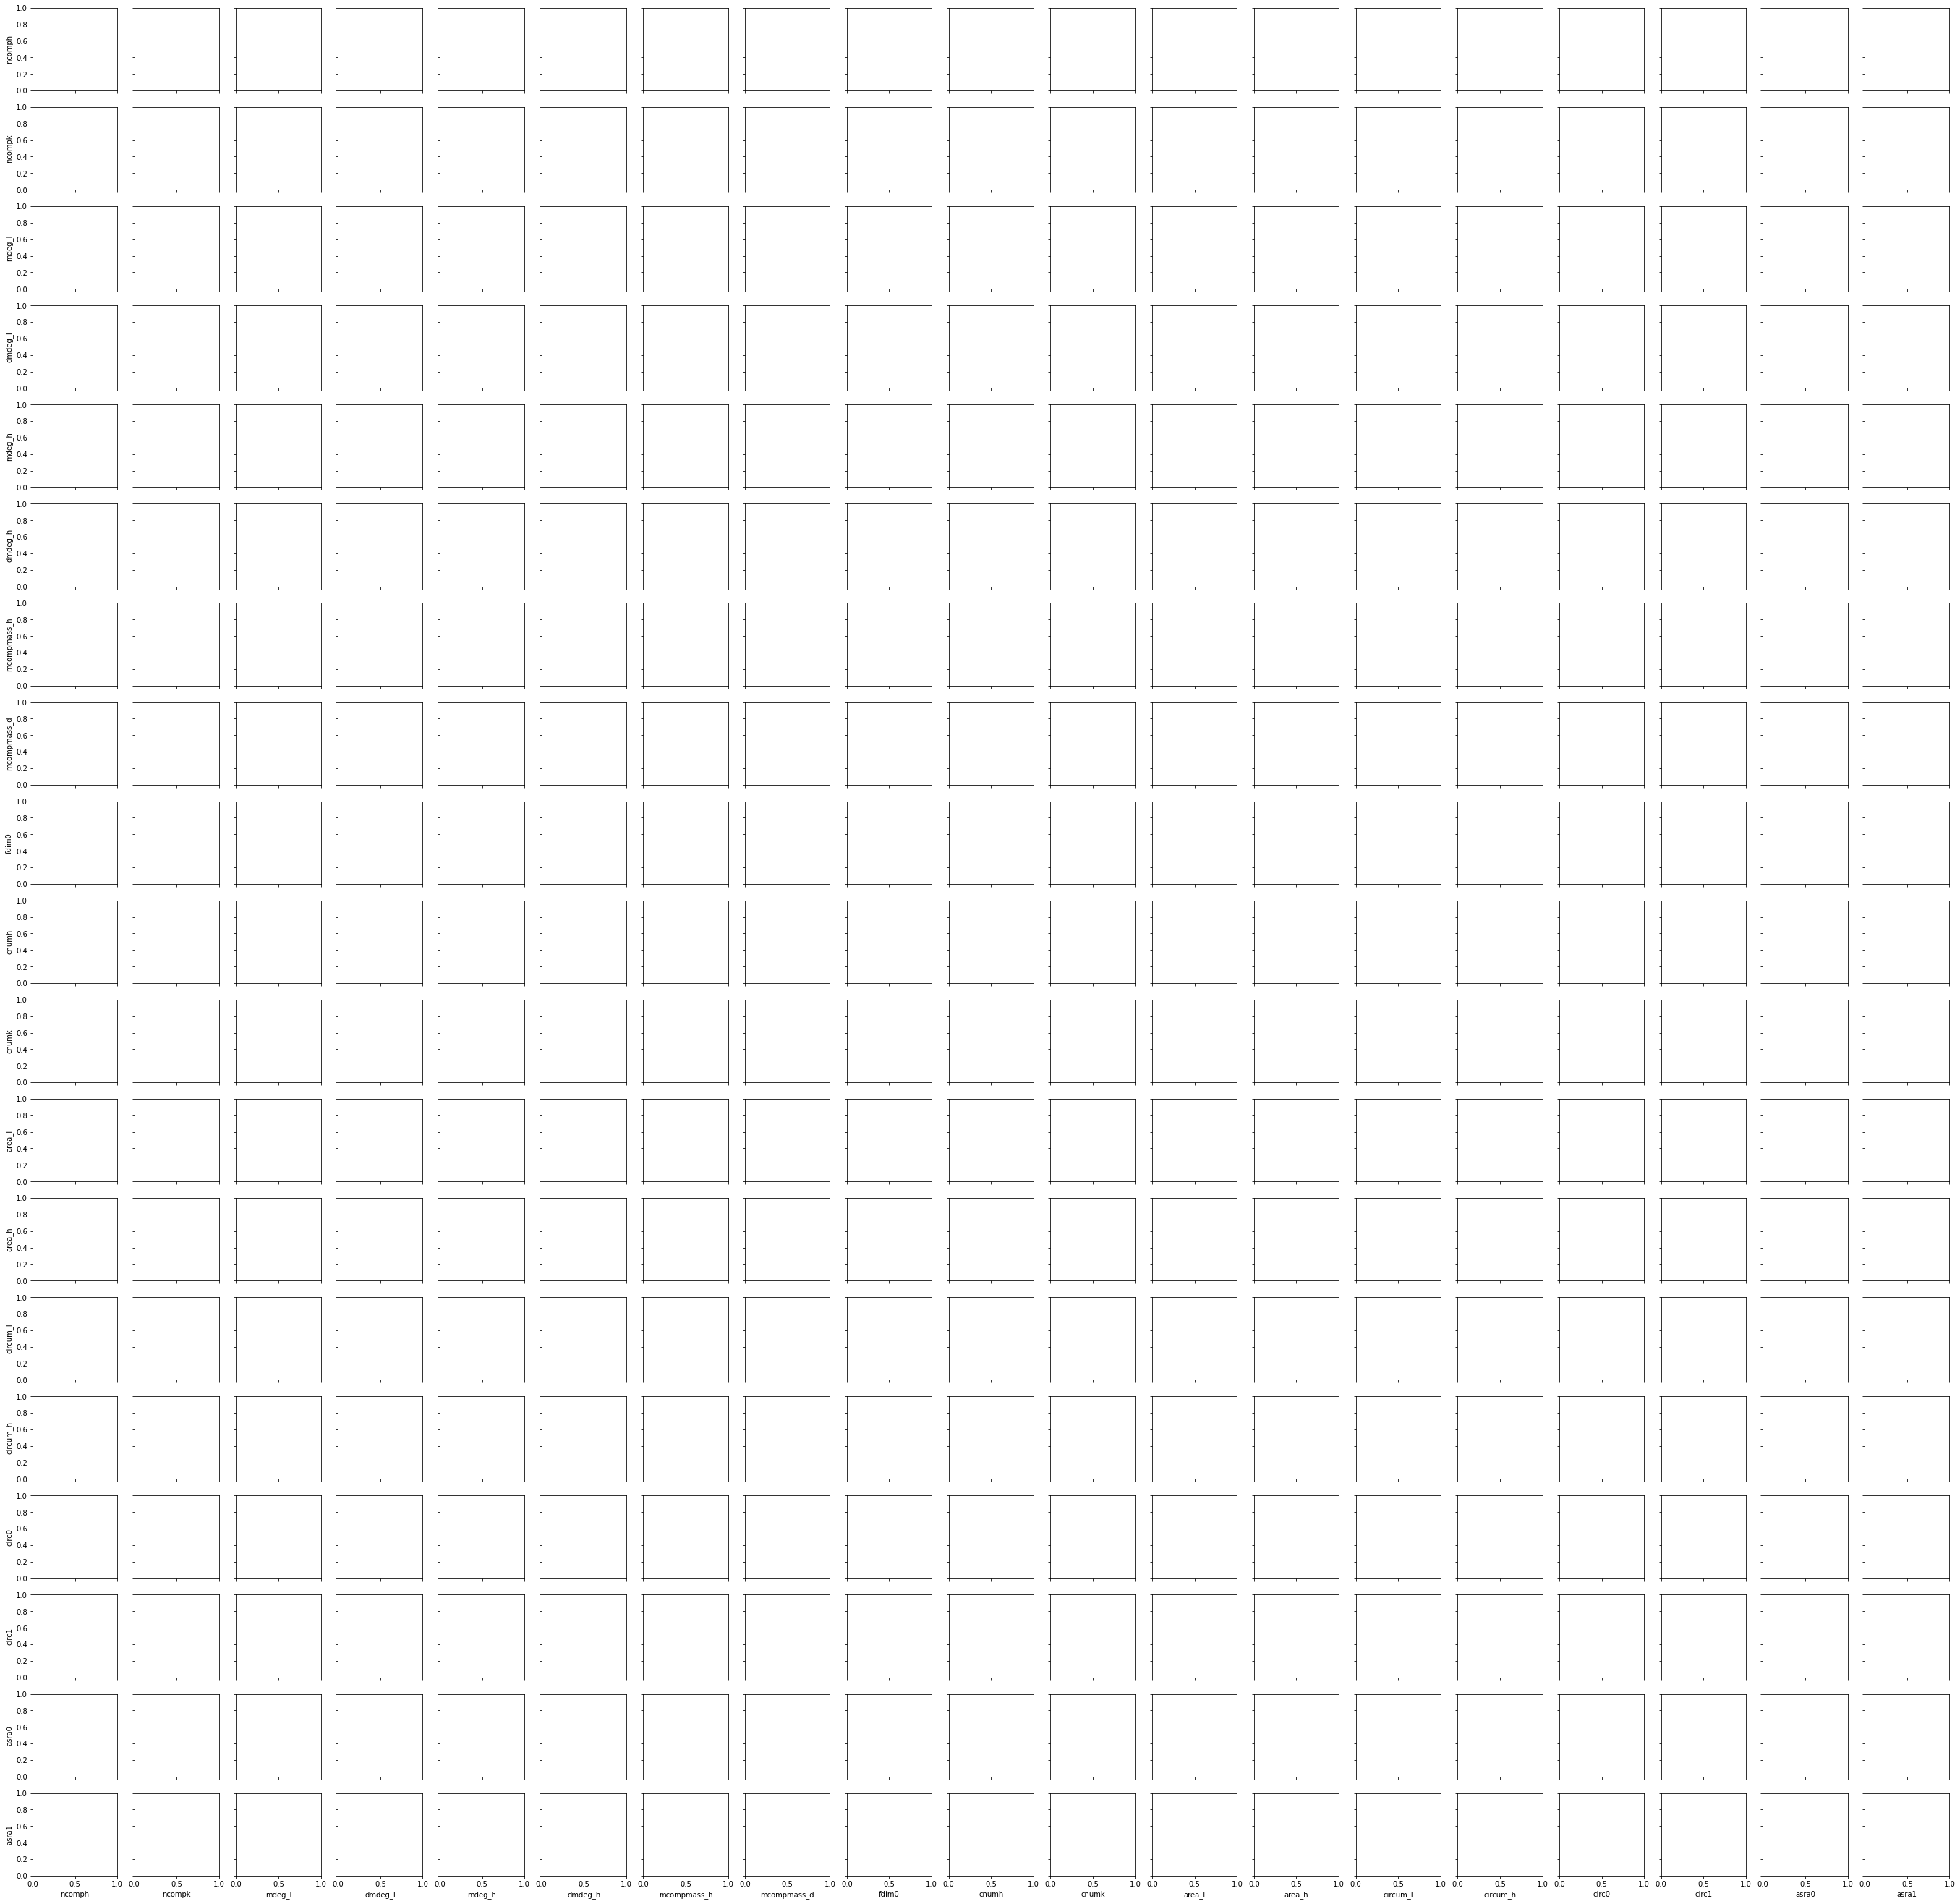

In [11]:
sns.pairplot(df, hue='line', plot_kws={'alpha':0.2})
plt.savefig("linvar_heatmap.png")

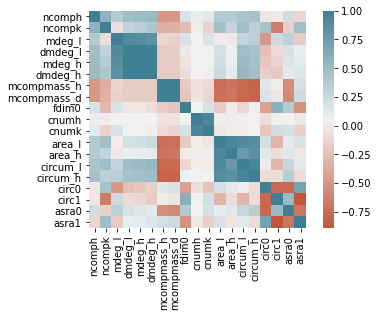

In [14]:
# plot the heatmap
sns.heatmap(df.corr(), 
           cmap=sns.diverging_palette(20, 220, n=200),
           square=True,
           )
plt.savefig("linvar_heatmap.png", dpi = 75)

In [28]:
lineage_path = "/Volumes/TC_backup/SCC_YM/p1/1.1"
out_lineage = lineage_timeless(lineage_path, lineage_path, calc_fdim = False)

/Volumes/TC_backup/SCC_YM/p1/1.1: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]

load failed for /Volumes/TC_backup/SCC_YM/p1/1.1/MC176229_instances.data


In [32]:
dir(out_lineage.items[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adjacency_list',
 'average_degree',
 'avgscore',
 'calc_chromatic',
 'calc_entropy',
 'calc_fractal_dim',
 'cell_areas',
 'cell_circularities',
 'cell_list',
 'cell_majaxes',
 'cell_minaxes',
 'cell_perimeters',
 'cell_scores',
 'centroid_list',
 'construct_adjacencies',
 'construct_centroid_list',
 'construct_graph',
 'construct_polygon_list',
 'degree_variance',
 'density',
 'densityHistogram',
 'fit_power',
 'fractal_dim',
 'get_component_masses',
 'get_largest_comp_ratio',
 'get_max_comp_mass',
 'graph',
 'image',
 'instances',
 'num_components',
 'number',
 'pickle_object',
 'plot_degree',
 'tag',
 'visualize_adjace

In [64]:
for i, lin in enumerate(lineage_list):
    if "YMR" in lin.tag: print(i,lin.tag)

0 YMR_0
1 YMR_1.1
2 YMR_1.2
3 YMR_1.3
4 YMR_1.4
5 YMR_1.5
6 YMR_10.1
7 YMR_10.2
8 YMR_10.3
9 YMR_10.4
10 YMR_10.5
11 YMR_10.6
12 YMR_11.1
13 YMR_11.2
14 YMR_11.4
15 YMR_11.5
16 YMR_11.6
17 YMR_12.2
18 YMR_12.3
19 YMR_12.4
20 YMR_12.5
21 YMR_12.6
22 YMR_13.1
23 YMR_13.2
24 YMR_13.3
25 YMR_13.4
26 YMR_13.5
27 YMR_14.1
28 YMR_14.2
29 YMR_14.3
30 YMR_14.4
31 YMR_14.6
32 YMR_15.1
33 YMR_15.3
34 YMR_15.4
35 YMR_16.1
36 YMR_16.2
37 YMR_16.3
38 YMR_16.4
39 YMR_16.5
40 YMR_2.1
41 YMR_2.2
42 YMR_2.4
43 YMR_2.5
44 YMR_2.6
45 YMR_3.2
46 YMR_3.3
47 YMR_3.5
48 YMR_3.6
49 YMR_4.1
50 YMR_4.6
51 YMR_5.1
52 YMR_5.2
53 YMR_5.3
54 YMR_5.4
55 YMR_6.1
56 YMR_6.2
57 YMR_6.3
58 YMR_6.4
59 YMR_6.5
60 YMR_6.6
61 YMR_7.1
62 YMR_7.2
63 YMR_7.3
64 YMR_7.4
65 YMR_7.5
66 YMR_7.6
67 YMR_8.1
68 YMR_9.1
69 YMR_9.3
70 YMR_9.4
71 YMR_9.5
72 YMR_9.6
73 YMR_pre11
74 YMR_pre14
75 YMR_pre20
76 YMR_pre21
77 YMR_pre25
78 YMR_pre28
79 YMR_pre38
80 YMR_pre41
81 YMR_pre7


In [75]:
lin = 76
[(i,thing.number, lineage_list[lin].items[i].tag[35:]) for i,thing in enumerate(lineage_list[lin].items)]

[(0, 76, 'YMR_pre21/MC171470_instances.data'),
 (1, 77, 'YMR_pre21/MC171471_instances.data'),
 (2, 58, 'YMR_pre21/MC171472_instances.data'),
 (3, 54, 'YMR_pre21/MC171473_instances.data'),
 (4, 50, 'YMR_pre21/MC171474_instances.data'),
 (5, 36, 'YMR_pre21/MC171475_instances.data'),
 (6, 78, 'YMR_pre21/MC171476_instances.data'),
 (7, 48, 'YMR_pre21/MC171477_instances.data'),
 (8, 60, 'YMR_pre21/MC171478_instances.data'),
 (9, 77, 'YMR_pre21/MC171479_instances.data'),
 (10, 66, 'YMR_pre21/MC171480_instances.data'),
 (11, 103, 'YMR_pre21/MC171481_instances.data'),
 (12, 70, 'YMR_pre21/MC171482_instances.data'),
 (13, 73, 'YMR_pre21/MC171483_instances.data'),
 (14, 45, 'YMR_pre21/MC171484_instances.data'),
 (15, 50, 'YMR_pre21/MC171485_instances.data'),
 (16, 89, 'YMR_pre21/MC171486_instances.data'),
 (17, 94, 'YMR_pre21/MC171487_instances.data'),
 (18, 83, 'YMR_pre21/MC171488_instances.data'),
 (19, 129, 'YMR_pre21/MC171489_instances.data'),
 (20, 272, 'YMR_pre21/MC171710_instances.data'),

In [50]:
dir(lineage_list[122].items[21])

IndexError: list index out of range

In [43]:
import hdbscan

testdf = finalDf.copy(deep=True)
testdf.pop('lineage')

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(testdf)

In [46]:
cluster_labels


array([ 1,  0,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,
        1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
        1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1,
        0, -1,  0, -1, -1, -1, -1,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1,
       -1,  0,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,
        0,  0, -1, -1, -1,  0, -1, -1,  0, -1, -1,  0, -1,  0,  0, -1, -1,
        0,  0,  0,  0,  0, -1, -1, -1,  0, -1, -1,  0, -1, -1, -1, -1, -1,
        0,  0,  0])